In [2]:
title: "Final Project"
subtitle: "Data Capture and Storage Check-In"
author: "Simone Haywood"
date: last-modified
format: 
   #html:
     #df-print: paged
     #mbed-resources: true

## Import the necessary libaries

[Optionally] Install the firebase-admin SDK for Python.  This is used to connect to the firebase database to get the data for the final project.
- Replace *pip3* with the appropriate python package installer based on your python installation.

In [1]:
import pandas as pd # Pandas is a python library used for data analysis.
import json #json is a library for dealing with JSON data.
from datetime import datetime # to handle converting the timestamp objects from firebase's SDK to ISO standard.

import firebase_admin
from firebase_admin import credentials, firestore

## Initialize Firebase Admin SDK

The code below assumes the firebase secret credentials, signal_caler.json, is located in the same directly as this notebook.


In [2]:
# Use your service account key JSON file
cred = credentials.Certificate("signal_caller.json")
firebase_admin.initialize_app(cred)

# Get Firestore client
db = firestore.client()

# Utility Functions

In [3]:
# This function recursivlly converts datetime objects from firebase's datetimeWithNanoseconds object type to the ISO8601 standard that works great with Pandas.

def datetimeWithNanoseconds_to_ISO8601(obj):
    """
    Recursively convert DatetimeWithNanoseconds objects to ISO 8601 strings,
    and leave all other values unchanged.

    Args:
        obj: Any Python object (likely a dict, list, or Firestore result) to sanitize.

    Returns:
        A new object with all DatetimeWithNanoseconds values converted to strings.
    """
    from google.cloud.firestore_v1._helpers import DatetimeWithNanoseconds
    from datetime import datetime

    if isinstance(obj, DatetimeWithNanoseconds):
        return obj.isoformat()
    elif isinstance(obj, dict):
        return {k: datetimeWithNanoseconds_to_ISO8601(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [datetimeWithNanoseconds_to_ISO8601(i) for i in obj]
    else:
        return obj

# Extract Data from Firebase Database

## Extract Signal Playbook Data

In [4]:
signal_playbook_collection = db.collection('signal_playbook').stream()
signal_playbook_data = {}
for doc in signal_playbook_collection:
    signal_playbook_data[doc.id] = doc.to_dict()

signal_playbook_data = datetimeWithNanoseconds_to_ISO8601(signal_playbook_data)
signal_playbook_data

{'collapse_left': {'mechanic': 'A directional collapse inward from the left — used to break protection schemes and force a disrupted response from the opponent’s offense.',
  'type': 'Defense',
  'historical_context': 'Mirrors the 1988 goal-line stand vs. Miami. Inches from the goal, the Irish defense locked in with perfect discipline and grit. This call is a tactical reminder of collective pressure and precise execution.',
  'latin_codename': 'Cuneus Deflectere',
  'translation': 'Wedge Collapse',
  'name': 'Collapse Left',
  'motionGuideImage': '/left.png',
  'gesture': '<'},
 'irish_surge': {'type': 'Offense',
  'mechanic': 'A forward-driving signal that initiates a direct, aggressive push — designed to break through the front line and open a clear path.',
  'historical_context': 'Based on the 2005 “Bush Push” vs. USC. Under extreme pressure, the Irish offense surged with urgency and power. This call reflects Notre Dame’s commitment to driving through adversity to reach the end zone

## Extract Users Data



In [5]:
users_collection = db.collection('users').stream()
users_data = {}
for doc in users_collection:
    users_data[doc.id] = doc.to_dict()

users_data = datetimeWithNanoseconds_to_ISO8601(users_data)
users_data

{'3T02i8MvMYV0f7Xz7MCnvyLMpLG3': {'id': '3T02i8MvMYV0f7Xz7MCnvyLMpLG3',
  'name': 'Andrew Benedum',
  'activeCourseId': 'SU25-DS-60620-01',
  'activeCourseName': 'Databases and Data Architecture (Summer 2025)',
  'createdAt': '2025-07-09T17:05:35.042000+00:00',
  'email': 'abenedum@nd.edu',
  'updatedAt': '2025-07-10T14:40:50.519000+00:00',
  'age': 27},
 '7hOsavOpK9hQ53r43R19b8kHxS72': {'id': '7hOsavOpK9hQ53r43R19b8kHxS72',
  'name': 'Bryan Massoth',
  'activeCourseId': 'SU25-DS-60620-01',
  'activeCourseName': 'Databases and Data Architecture (Summer 2025)',
  'createdAt': '2025-06-15T05:06:36.240000+00:00',
  'email': 'btmassoth@gmail.com',
  'updatedAt': '2025-06-15T05:06:36.240000+00:00',
  'age': 32},
 'A7P5QM0SuEh30sbaJVr4DwwQvpz2': {'id': 'A7P5QM0SuEh30sbaJVr4DwwQvpz2',
  'name': 'd rd',
  'activeCourseId': 'SU25-DS-60620-01',
  'activeCourseName': 'Databases and Data Architecture (Summer 2025)',
  'createdAt': '2025-06-15T02:40:21.079000+00:00',
  'email': 'daniel.r.douce@gmai

## Extract the Signal Recordings

This code connects to our Firebase Firestore database and pulls all the documents from the signal_recordings collection.  

Signal Recordings contain the timeseries of sensor measurements.

In [6]:
signal_recording_collection = db.collection('signal_recordings').stream()
signal_recordings_data = {}
for doc in signal_recording_collection:
    signal_recordings_data[doc.id] = doc.to_dict()

signal_recordings_data = datetimeWithNanoseconds_to_ISO8601(signal_recordings_data)

> **signal_recordings_data** is a VERY large dictonary. Don't print the entire thing to your console or you may crash your browser or vscode.

In [7]:
# Safely preview the data in this dictionary
def preview_signals(signal_recordings_data, n=2):
    """
    Pretty-print the first `n` signal recordings, showing all metadata and
    only the first and last measurement rows from the 'data' field.

    Args:
        signal_recordings_data (dict): Dictionary of signal recordings keyed by document ID.
        n (int): Number of signal recordings to preview. Default is 1.

    Notes:
        - Each signal's metadata is fully printed.
        - Only the first and last rows from 'data' are shown for brevity.
    """

    if not signal_recordings_data:
        print("⚠️ No signal recordings found.")
        return

    keys = list(signal_recordings_data.keys())[:n]

    for idx, key in enumerate(keys, 1):
        print(f"\n📄 Signal {idx}: Document ID = {key}\n")

        signal_data = signal_recordings_data[key]

        print("=== Metadata ===")
        for meta_key, meta_value in signal_data.items():
            if meta_key != 'data':
                print(f"{meta_key}: {meta_value}")

        data = signal_data.get("data", [])
        if not data:
            print("⚠️ No signal data found in 'data' field.")
            continue

        print("\n=== First row of data[] ===")
        print(f"[0] {json.dumps(data[0], indent=2)}")

        print("\n=== Last row of data[] ===")
        print(f"[{len(data) - 1}] {json.dumps(data[-1], indent=2)}")


In [8]:
preview_signals(signal_recordings_data)


📄 Signal 1: Document ID = 1DlnbeuO7ggujkFLGkvG

=== Metadata ===
durationMs: 3935
playId: irish_surge
playName: Irish Surge
timestamp: 2025-06-15T02:43:36.130000+00:00
userId: A7P5QM0SuEh30sbaJVr4DwwQvpz2

=== First row of data[] ===
[0] {
  "accelerationIncludingGravity": {
    "z": 5.4,
    "y": 8.6,
    "x": 0.7000000000000001
  },
  "timestamp": 8,
  "acceleration": {
    "z": 0.6000000000000001,
    "y": -0.0,
    "x": -0.0
  },
  "rotationRate": {
    "gamma": 14.100000000000001,
    "beta": 1,
    "alpha": -12.7
  }
}

=== Last row of data[] ===
[233] {
  "accelerationIncludingGravity": {
    "z": 3.1,
    "y": 9.8,
    "x": -0.2
  },
  "timestamp": 3920,
  "acceleration": {
    "z": -1.2000000000000002,
    "y": 1.1,
    "x": 0.7000000000000001
  },
  "rotationRate": {
    "beta": 9.700000000000001,
    "gamma": 3.1,
    "alpha": -8.2
  }
}

📄 Signal 2: Document ID = 1IJGEH5GaHkk1lhJqa8Q

=== Metadata ===
durationMs: 3310
playName: Collapse Left
timestamp: 2025-06-15T02:41:03.

# Transform

TODO: Transform the dictionaries into tables that can then be loaded into your target database.

In [9]:
import pandas as pd

In [10]:
#users data to dataframe 
users_info = []
for key in users_data:
    d = users_data.get(key)
    users_info.append(d)
users_info
pd.DataFrame(users_info)

,id,name,activeCourseId,activeCourseName,createdAt,email,updatedAt,age
0,3T02i8MvMYV0f7Xz7MCnvyLMpLG3,Andrew Benedum,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-07-09T17:05:35.042000+00:00,abenedum@nd.edu,2025-07-10T14:40:50.519000+00:00,27
1,7hOsavOpK9hQ53r43R19b8kHxS72,Bryan Massoth,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-06-15T05:06:36.240000+00:00,btmassoth@gmail.com,2025-06-15T05:06:36.240000+00:00,32
2,A7P5QM0SuEh30sbaJVr4DwwQvpz2,d rd,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-06-15T02:40:21.079000+00:00,daniel.r.douce@gmail.com,2025-06-15T02:40:21.079000+00:00,43
3,DtFQaogasuVGQ7usVu0V4Qhn6BU2,Jade Liggett,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-06-17T16:38:50.711000+00:00,jadeliggett21@gmail.com,2025-06-17T16:38:50.711000+00:00,30
4,EMqtMc0U5DM40FAplfHIAWWMEuq1,Ricardo Ramirez,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-07-16T06:15:16.816000+00:00,rramir22@nd.edu,2025-07-16T06:15:16.816000+00:00,32
5,EMr3nqqL6ygD1MYdgxrJosFUzn63,Bridget Liesman,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-06-28T15:32:53.291000+00:00,bliesman@nd.edu,2025-06-28T15:32:53.291000+00:00,28
6,Gj9r95rnXdT2pSyXwA3D2mTG2iK2,Chris Frederick,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-06-17T02:18:08.788000+00:00,chris@sbcodeworks.com,2025-06-17T02:18:08.788000+00:00,46
7,Lpdfv7XnLMQ5gVb46Rc6K9DhgWN2,Sean Lyons,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-07-01T13:33:51.477000+00:00,slyons7@nd.edu,2025-07-02T01:54:43.399000+00:00,23
8,M9GfFK2s7PhEUcy4PfQvvcoJvPJ3,Austin Lee,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-07-07T02:28:49.233000+00:00,wlee25@nd.edu,2025-07-26T06:41:09.752000+00:00,31
9,NCMa58qu9UaHHMEbuNxzuphjm1v2,Gabby Salera,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-07-20T19:51:49.107000+00:00,gsalera@nd.edu,2025-07-20T19:51:49.107000+00:00,26


In [11]:
#signal playbook data to dataframe 
signal_playbook_info = []
for key in signal_playbook_data:
    d = signal_playbook_data[key]
    signal_playbook_info.append(d)
signal_playbook_info
pd.DataFrame(signal_playbook_info)

,mechanic,type,historical_context,latin_codename,translation,name,motionGuideImage,gesture
0,A directional collapse inward from the left — ...,Defense,Mirrors the 1988 goal-line stand vs. Miami. In...,Cuneus Deflectere,Wedge Collapse,Collapse Left,/left.png,<
1,A forward-driving signal that initiates a dire...,Offense,Based on the 2005 “Bush Push” vs. USC. Under e...,Impulsus Ferrum,Iron Surge,Irish Surge,/N.png,N
2,"Double circular motion — boosts team tempo, sy...",12th Man,Echoes the 1973 Sugar Bowl when the home crowd...,Anima Stadium,Spirit of the Stadium,Touchdown Halo,/O.png,O (Circle x2)


In [12]:
#flatten signal recordings data into a header and detail tables
signal_recordings_header = []
signal_recordings_detail = []

for signal_id in signal_recordings_data:
    signal_dict = signal_recordings_data.get(signal_id)
    timestamp = signal_dict.get('timestamp')
    playName = signal_dict.get('playName')
    playId = signal_dict.get('playId')
    userId = signal_dict.get('userId')
    durationMs = signal_dict.get('durationMs')
    
    signal_recordings_header.append({
        'signalID': signal_id,
        'timestamp':timestamp,
        'playName':playName,
        'playId':playId,
        'userId':userId,
        'durationMs':durationMs,
    })

    data_list = signal_dict.get('data')
    for data_dict in data_list:
        x = data_dict.get('acceleration').get('x')
        y = data_dict.get('acceleration').get('y')
        z = data_dict.get('acceleration').get('z')
        alpha = data_dict.get('rotationRate').get('alpha')
        beta = data_dict.get('rotationRate').get('beta')
        gamma = data_dict.get('rotationRate').get('gamma')
        timestamp = data_dict.get('timestamp')

        signal_recordings_detail.append({
            'signalID': signal_id,
            'accl_x': x,
            'accl_y': y,
            'accl_z': z,
            'rotation_alpha': alpha,
            'rotation_beta': beta,
            'rotation_gamma': gamma,
            'timestamp_seq_num': timestamp

        })
pd.DataFrame(signal_recordings_header)

,signalID,timestamp,playName,playId,userId,durationMs
0,1DlnbeuO7ggujkFLGkvG,2025-06-15T02:43:36.130000+00:00,Irish Surge,irish_surge,A7P5QM0SuEh30sbaJVr4DwwQvpz2,3935
1,1IJGEH5GaHkk1lhJqa8Q,2025-06-15T02:41:03.843000+00:00,Collapse Left,collapse_left,yyJqKEAv0qZCzmksNJA26VVizfE3,3310
2,29Ha6Y92iCipu8yPCwhZ,2025-07-25T16:10:59.465000+00:00,Irish Surge,irish_surge,Q55o2vIYKiOHUpN7hQk5oQEPrDd2,4384
3,2aSWziIFSvFAn0gOzmk5,2025-07-20T02:21:33.670000+00:00,Touchdown Halo,touchdown_halo,PIYoM7g2NPeWCyJzADmC8Q3AoNU2,4272
4,47UgyhAVQeGbf81EHWCL,2025-06-15T02:44:46.322000+00:00,Touchdown Halo,touchdown_halo,yyJqKEAv0qZCzmksNJA26VVizfE3,3717
...,...,...,...,...,...,...
113,wH8FpscdI1uMm7VUPM7d,2025-06-15T02:44:02.482000+00:00,Collapse Left,collapse_left,A7P5QM0SuEh30sbaJVr4DwwQvpz2,2141
114,xnQr3xdH4SP8uEb33vCg,2025-06-15T02:40:59.211000+00:00,Collapse Left,collapse_left,A7P5QM0SuEh30sbaJVr4DwwQvpz2,2374
115,y7TAmPnBgwd1ZgINn8cz,2025-07-20T02:22:17.587000+00:00,Touchdown Halo,touchdown_halo,PIYoM7g2NPeWCyJzADmC8Q3AoNU2,5007
116,z7QhU8w2GZhAjkiEC1Ed,2025-07-26T01:12:29.863000+00:00,Touchdown Halo,touchdown_halo,PIYoM7g2NPeWCyJzADmC8Q3AoNU2,4407


In [13]:
pd.DataFrame(signal_recordings_detail)

,signalID,accl_x,accl_y,accl_z,rotation_alpha,rotation_beta,rotation_gamma,timestamp_seq_num
0,1DlnbeuO7ggujkFLGkvG,-0.000000,-0.000000,0.600000,-12.700000,1.000000,14.100000,8
1,1DlnbeuO7ggujkFLGkvG,0.000000,-0.000000,0.000000,-2.900000,5.900000,0.300000,71
2,1DlnbeuO7ggujkFLGkvG,0.100000,-0.000000,0.000000,-3.800000,7.800000,1.300000,86
3,1DlnbeuO7ggujkFLGkvG,-0.000000,0.000000,0.000000,-7.800000,3.400000,1.000000,103
4,1DlnbeuO7ggujkFLGkvG,-0.100000,-0.000000,0.300000,-8.500000,-0.300000,1.300000,120
...,...,...,...,...,...,...,...,...
28131,zXrKF0R3HdNp06LYdJvq,-0.367309,1.713778,3.817070,38.487235,-69.422132,18.146954,3110
28132,zXrKF0R3HdNp06LYdJvq,-4.882896,0.914221,9.363792,-55.684388,-27.869728,-6.539347,3127
28133,zXrKF0R3HdNp06LYdJvq,-1.974081,0.897204,1.492637,-53.131891,-7.413343,-14.143733,3142
28134,zXrKF0R3HdNp06LYdJvq,-1.716032,0.144629,-4.518754,-14.197873,22.010886,-29.998447,3159


# Create

TODO: Create your target database schema using the appropriate tools and techniques for your selected data architecture. 

In [14]:
import getpass

# Define PostgreSQL database connection parameters
user = input("Username (NetID):")
host = input("Host:") #"p-52l4px4ox6.pg.biganimal.io"
dbname = input("Database:") #imdb
port = "5432"
password = getpass.getpass("Password:") # Get pass will prompt the user for a password without echoing.

In [15]:
import pandas as pd
db_URI = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}"

In [16]:
import psycopg2  # Python database adapter for PostgreSQL database

# A helper function to open a psycopg2 connection, set auto-commit to true, execute the sql, and close the connection.
def execute_sql(sql, echo=True):
    try:
        pg_conn = psycopg2.connect(
            dbname=dbname,
            user=user,
            password=password,
            host=host,
            port=port
        )
    except psycopg2.Error as e:
        error_message = e.pgerror
        print("Error Connecting:", error_message)

    # Set the connection to autocommit (everything is treated as an individual transaction)
    pg_conn.set_session(autocommit=True)
    
    # The cursor is used to execute our ddl statements.
    pg_cursor = pg_conn.cursor() 
    
    try:
        pg_cursor.execute(sql)
        if echo:
            print(sql)
    except psycopg2.Error as e:
        error_message = e.pgerror
        print("SQL Failed:", error_message)
    
    pg_conn.close()

In [18]:
#creation of user dimension table
ddl = """
CREATE TABLE user_dim (
    user_key integer GENERATED BY DEFAULT AS identity primary key,
    user_id varchar UNIQUE,
    name varchar,
    email varchar UNIQUE,
    age integer,
    active_course_id varchar,
    active_course_name varchar,
    created_timestamp timestamp,
    etl_load_timestamp timestamp
);
"""
execute_sql(ddl)


CREATE TABLE user_dim (
    user_key integer GENERATED BY DEFAULT AS identity primary key,
    user_id varchar UNIQUE,
    name varchar,
    email varchar UNIQUE,
    age integer,
    active_course_id varchar,
    active_course_name varchar,
    created_timestamp timestamp,
    etl_load_timestamp timestamp
);



In [22]:
#creation of play dimension table
ddl = """
CREATE TABLE play_dim (
    play_key integer GENERATED BY DEFAULT AS identity primary key,
    play_name varchar,
    translation varchar, 
    type varchar,
    motion_guide_image varchar,
    gesture varchar,
    mechanic text, 
    latin_name varchar,
    historical_context text,
    etl_load_timestamp timestamp
);
"""
execute_sql(ddl)


CREATE TABLE play_dim (
    play_key integer GENERATED BY DEFAULT AS identity primary key,
    play_name varchar,
    translation varchar, 
    type varchar,
    motion_guide_image varchar,
    gesture varchar,
    mechanic text, 
    latin_name varchar,
    historical_context text,
    etl_load_timestamp timestamp
);



In [24]:
#creation of date dimension table
ddl = """
CREATE TABLE date_dim (
    date_key integer GENERATED BY DEFAULT AS identity primary key,
    full_date date,
    num_day integer,
    day_name varchar,
    month_num integer,
    month_name varchar,
    day_of_month integer,
    fiscal_week integer,
    quarter integer,
    quarter_name varchar,
    year integer,
    is_weekend boolean,
    is_holiday boolean
);
"""
execute_sql(ddl)


CREATE TABLE date_dim (
    date_key integer GENERATED BY DEFAULT AS identity primary key,
    full_date date,
    num_day integer,
    day_name varchar,
    month_num integer,
    month_name varchar,
    day_of_month integer,
    fiscal_week integer,
    quarter integer,
    quarter_name varchar,
    year integer,
    is_weekend boolean,
    is_holiday boolean
);



In [26]:
#creation of time dimension table
ddl = """
CREATE TABLE time_dim (
    time_key integer GENERATED BY DEFAULT AS identity primary key,
    full_time time,
    hour integer,
    minute integer,
    second integer,
    time_of_day varchar
);
"""
execute_sql(ddl)


CREATE TABLE time_dim (
    time_key integer GENERATED BY DEFAULT AS identity primary key,
    full_time time,
    hour integer,
    minute integer,
    second integer,
    time_of_day varchar
);



In [51]:
#creation of play call attempt fact table 
ddl = """
CREATE TABLE playcallattempt_fact (
    play_call_attempt_id varchar NOT NULL primary key,
    play_key integer REFERENCES play_dim (play_key),
    date_key integer REFERENCES date_dim (date_key),
    signal_recording_id varchar NOT NULL,
    accl_x numeric, 
    accl_y numeric,
    accl_z numeric,
    rotation_alpha numeric,
    rotation_beta numeric,
    rotation_gamma numeric,
    timestamp_seq_num integer,
    timestamp_signal timestamp,
    etl_load_timestamp timestamp
);
"""
execute_sql(ddl)


CREATE TABLE playcallattempt_fact (
    play_call_attempt_id varchar NOT NULL primary key,
    play_key integer REFERENCES play_dim (play_key),
    date_key integer REFERENCES date_dim (date_key),
    signal_recording_id varchar NOT NULL,
    accl_x numeric, 
    accl_y numeric,
    accl_z numeric,
    rotation_alpha numeric,
    rotation_beta numeric,
    rotation_gamma numeric,
    timestamp_seq_num integer,
    timestamp_signal timestamp,
    etl_load_timestamp timestamp
);



# Load

TODO: Actually load the data into your target database so that you can later write SQL queries and explore the data.

In [29]:
import numpy as np
from sqlalchemy import create_engine, text
from datetime import datetime
import holidays 
engine = create_engine(db_URI)

##### Loading the Date and Time Data

In [30]:
#date_dim dataframe
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2035-12-31')
dates = pd.date_range(start=start_date,end=end_date,freq='D')
us_holidays = holidays.US(years=range(2015, 2035))

In [31]:
date_dim_data = []
for single_date in dates:
    is_holiday_flag = single_date.date() in us_holidays #importing the holidays for boolean holiday flag
    date_key = int(single_date.strftime('%Y%m%d')) #formatting for date

    date_dim_data.append({
        'date_key': date_key,
        'full_date': single_date.normalize(),
        'num_day': single_date.dayofweek + 1, #updating to change to day of week numerically
        'day_name': single_date.day_name(),
        'month_num': single_date.month, 
        'month_name': single_date.strftime('%B'), #converting the number date to name
        'day_of_month': single_date.day,
        'fiscal_week': single_date.isocalendar()[1], 
        'quarter': single_date.quarter,
        'quarter_name': f"Q{single_date.quarter}",
        'year': single_date.year,
        'is_weekend': single_date.dayofweek >= 5,
        'is_holiday': is_holiday_flag
    })

date_info_df = pd.DataFrame(date_dim_data)
date_info_df = date_info_df.where(pd.notnull(date_info_df), None)
date_info_df.to_sql("date_dim", con=db_URI, index=False, if_exists='append', method='multi')

7670

In [32]:
ddl = """SELECT * FROM date_dim ORDER BY date_key DESC LIMIT 10;"""
date_dim_df = pd.read_sql(ddl, db_URI) #creation of date_dim data frame and loading data 

In [155]:
date_dim_df.head()

,date_key,full_date,num_day,day_name,month_num,month_name,day_of_month,fiscal_week,quarter,quarter_name,year,is_weekend,is_holiday
0,20351231,2035-12-31,1,Monday,12,December,31,1,4,Q4,2035,False,False
1,20351230,2035-12-30,7,Sunday,12,December,30,52,4,Q4,2035,True,False
2,20351229,2035-12-29,6,Saturday,12,December,29,52,4,Q4,2035,True,False
3,20351228,2035-12-28,5,Friday,12,December,28,52,4,Q4,2035,False,False
4,20351227,2035-12-27,4,Thursday,12,December,27,52,4,Q4,2035,False,False


In [33]:
#time_dim dataframe
import datetime

time_date = datetime.date(2015, 1, 1)

time_dim_data = []
for h in range(24):
    for m in range(60):
        for s in range(60):
            time_obj = datetime.time(h, m, s) 
            full_timestamp = datetime.datetime.combine(time_date, time_obj)
            time_of_day_label = 'PM' if h >= 12 else 'AM'
            time_dim_data.append({
                'full_time': full_timestamp,
                'hour': h,
                'minute': m,
                'second': s,
                'time_of_day': time_of_day_label
            })

time_info_df = pd.DataFrame(time_dim_data)
time_info_df.to_sql("time_dim",con=db_URI,index=False,if_exists='append',method='multi')

86400

In [34]:
ddl = """SELECT * FROM time_dim ORDER BY time_key DESC LIMIT 10;"""
time_dim_df = pd.read_sql(ddl, db_URI) #creation of time_dim data frame and loading data 

In [154]:
time_dim_df.head()

,time_key,full_time,hour,minute,second,time_of_day
0,86400,23:59:59,23,59,59,PM
1,86399,23:59:58,23,59,58,PM
2,86398,23:59:57,23,59,57,PM
3,86397,23:59:56,23,59,56,PM
4,86396,23:59:55,23,59,55,PM


##### Loading the User Data

In [35]:
from datetime import datetime,timezone
users_info_df = pd.DataFrame(users_info)
users_info_df['etl_load_timestamp'] = datetime.now(timezone.utc)
users_info_df.head()

,id,name,activeCourseId,activeCourseName,createdAt,email,updatedAt,age,etl_load_timestamp
0,3T02i8MvMYV0f7Xz7MCnvyLMpLG3,Andrew Benedum,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-07-09T17:05:35.042000+00:00,abenedum@nd.edu,2025-07-10T14:40:50.519000+00:00,27,2025-07-28 06:13:52.219622+00:00
1,7hOsavOpK9hQ53r43R19b8kHxS72,Bryan Massoth,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-06-15T05:06:36.240000+00:00,btmassoth@gmail.com,2025-06-15T05:06:36.240000+00:00,32,2025-07-28 06:13:52.219622+00:00
2,A7P5QM0SuEh30sbaJVr4DwwQvpz2,d rd,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-06-15T02:40:21.079000+00:00,daniel.r.douce@gmail.com,2025-06-15T02:40:21.079000+00:00,43,2025-07-28 06:13:52.219622+00:00
3,DtFQaogasuVGQ7usVu0V4Qhn6BU2,Jade Liggett,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-06-17T16:38:50.711000+00:00,jadeliggett21@gmail.com,2025-06-17T16:38:50.711000+00:00,30,2025-07-28 06:13:52.219622+00:00
4,EMqtMc0U5DM40FAplfHIAWWMEuq1,Ricardo Ramirez,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-07-16T06:15:16.816000+00:00,rramir22@nd.edu,2025-07-16T06:15:16.816000+00:00,32,2025-07-28 06:13:52.219622+00:00


In [36]:
#renaming the columns to match the user_dim table to load the data 
users_info_df = users_info_df.rename(columns={
    "id": "user_id",
    "name": "name",
    "email": "email",
    "age": "age",
    "activeCourseId": "active_course_id",
    "activeCourseName": "active_course_name",
    "createdAt": "created_timestamp",
})

In [37]:
columns = ["user_id", "name", "email", "age", "active_course_id", "active_course_name","created_timestamp", "etl_load_timestamp"] #the columns needed for users_dim 
users_info_df = users_info_df[columns]
users_info_df['created_timestamp'] = pd.to_datetime(users_info_df['created_timestamp'])
users_info_df.to_sql("user_dim",con=db_URI,index=False,if_exists='append',method='multi')

28

In [38]:
ddl = """SELECT * FROM user_dim ORDER BY user_key DESC LIMIT 10;"""
users_dim_df = pd.read_sql(ddl, db_URI) #creation of user_dim data frame and loading data 

In [153]:
users_dim_df.head()

,user_key,user_id,name,email,age,active_course_id,active_course_name,created_timestamp,etl_load_timestamp
0,28,yyJqKEAv0qZCzmksNJA26VVizfE3,Justin Flagel,justin.flagel@gmail.com,43,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-06-15 02:40:16.591,2025-07-28 06:13:52.219622
1,27,xdcwE93cv8fiiU3pRuUx9Riy7cg1,Danielle McDowell,dstealy@nd.edu,41,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-07-10 12:51:19.430,2025-07-28 06:13:52.219622
2,26,xMuSkdXbS7MEk9AzFmJapSUEvdy1,Natasha Malik,nmalik2@nd.edu,32,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-07-21 03:58:52.960,2025-07-28 06:13:52.219622
3,25,sNDSCcBtCDbGlzCaRwVVOFfQDTF2,Christopher Frederick,cfreder2@nd.edu,46,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-06-14 16:35:25.808,2025-07-28 06:13:52.219622
4,24,pQrsQz8FRwQgV7Icl7yknMMCx4s2,Kevin Bursaw,kmbursaw@gmail.com,35,SU25-DS-60620-01,Databases and Data Architecture (Summer 2025),2025-07-03 00:30:39.424,2025-07-28 06:13:52.219622


##### Loading the Play Data

In [39]:
play_info_df = pd.DataFrame(signal_playbook_info)
play_info_df['etl_load_timestamp'] = datetime.now(timezone.utc) #add ETL timestamp
play_info_df.head()

,mechanic,type,historical_context,latin_codename,translation,name,motionGuideImage,gesture,etl_load_timestamp
0,A directional collapse inward from the left — ...,Defense,Mirrors the 1988 goal-line stand vs. Miami. In...,Cuneus Deflectere,Wedge Collapse,Collapse Left,/left.png,<,2025-07-28 06:14:01.302842+00:00
1,A forward-driving signal that initiates a dire...,Offense,Based on the 2005 “Bush Push” vs. USC. Under e...,Impulsus Ferrum,Iron Surge,Irish Surge,/N.png,N,2025-07-28 06:14:01.302842+00:00
2,"Double circular motion — boosts team tempo, sy...",12th Man,Echoes the 1973 Sugar Bowl when the home crowd...,Anima Stadium,Spirit of the Stadium,Touchdown Halo,/O.png,O (Circle x2),2025-07-28 06:14:01.302842+00:00


In [40]:
#renaming the columns to match the play_dim table to load the data 
play_info_df = play_info_df.rename(columns={
    "name": "play_name",
    "translation": "translation",
    "type": "type",
    "motionGuideImage": "motion_guide_image",
    "gesture": "gesture",
    "mechanic": "mechanic",
    "latin_codename": "latin_name",
    "historical_context": "historical_context",
})

In [41]:
columns = ["play_name", "translation", "type", "motion_guide_image", "gesture", "mechanic","latin_name", "historical_context", "etl_load_timestamp"]
play_info_df = play_info_df[columns]
play_info_df['etl_load_timestamp'] = datetime.now(timezone.utc) #add ETL timestamp
play_info_df = play_info_df.where(pd.notnull(play_info_df), None) #convert missing values to none if any
play_info_df.to_sql("play_dim",con=db_URI,index=False,if_exists='append',method='multi')

3

In [42]:
ddl = """SELECT * FROM play_dim ORDER BY play_key;"""
play_dim_df = pd.read_sql(ddl, db_URI) #creation of play_dim data frame and loading data 

In [84]:
play_dim_df.head()

,play_key,play_name,translation,type,motion_guide_image,gesture,mechanic,latin_name,historical_context,etl_load_timestamp
0,1,Collapse Left,Wedge Collapse,Defense,/left.png,<,A directional collapse inward from the left — ...,Cuneus Deflectere,Mirrors the 1988 goal-line stand vs. Miami. In...,2025-07-28 06:14:07.661857
1,2,Irish Surge,Iron Surge,Offense,/N.png,N,A forward-driving signal that initiates a dire...,Impulsus Ferrum,Based on the 2005 “Bush Push” vs. USC. Under e...,2025-07-28 06:14:07.661857
2,3,Touchdown Halo,Spirit of the Stadium,12th Man,/O.png,O (Circle x2),"Double circular motion — boosts team tempo, sy...",Anima Stadium,Echoes the 1973 Sugar Bowl when the home crowd...,2025-07-28 06:14:07.661857


##### Loading the Play Call Attempt  Data

In [43]:
signal_header_df = pd.DataFrame(signal_recordings_header)
signal_header_df['etl_load_timestamp'] = datetime.now(timezone.utc) #add ETL timestamp
signal_header_df['timestamp'] = pd.to_datetime(signal_header_df['timestamp']) #converting to a timestamp object
signal_header_df.head()

,signalID,timestamp,playName,playId,userId,durationMs,etl_load_timestamp
0,1DlnbeuO7ggujkFLGkvG,2025-06-15 02:43:36.130000+00:00,Irish Surge,irish_surge,A7P5QM0SuEh30sbaJVr4DwwQvpz2,3935,2025-07-28 06:14:12.233841+00:00
1,1IJGEH5GaHkk1lhJqa8Q,2025-06-15 02:41:03.843000+00:00,Collapse Left,collapse_left,yyJqKEAv0qZCzmksNJA26VVizfE3,3310,2025-07-28 06:14:12.233841+00:00
2,29Ha6Y92iCipu8yPCwhZ,2025-07-25 16:10:59.465000+00:00,Irish Surge,irish_surge,Q55o2vIYKiOHUpN7hQk5oQEPrDd2,4384,2025-07-28 06:14:12.233841+00:00
3,2aSWziIFSvFAn0gOzmk5,2025-07-20 02:21:33.670000+00:00,Touchdown Halo,touchdown_halo,PIYoM7g2NPeWCyJzADmC8Q3AoNU2,4272,2025-07-28 06:14:12.233841+00:00
4,47UgyhAVQeGbf81EHWCL,2025-06-15 02:44:46.322000+00:00,Touchdown Halo,touchdown_halo,yyJqKEAv0qZCzmksNJA26VVizfE3,3717,2025-07-28 06:14:12.233841+00:00


In [44]:
signal_details_df = pd.DataFrame(signal_recordings_detail)
signal_details_df['etl_load_timestamp'] = datetime.now(timezone.utc) #add ETL timestamp
signal_details_df.head()

,signalID,accl_x,accl_y,accl_z,rotation_alpha,rotation_beta,rotation_gamma,timestamp_seq_num,etl_load_timestamp
0,1DlnbeuO7ggujkFLGkvG,-0.0,-0.0,0.6,-12.7,1.0,14.1,8,2025-07-28 06:14:14.665306+00:00
1,1DlnbeuO7ggujkFLGkvG,0.0,-0.0,0.0,-2.9,5.9,0.3,71,2025-07-28 06:14:14.665306+00:00
2,1DlnbeuO7ggujkFLGkvG,0.1,-0.0,0.0,-3.8,7.8,1.3,86,2025-07-28 06:14:14.665306+00:00
3,1DlnbeuO7ggujkFLGkvG,-0.0,0.0,0.0,-7.8,3.4,1.0,103,2025-07-28 06:14:14.665306+00:00
4,1DlnbeuO7ggujkFLGkvG,-0.1,-0.0,0.3,-8.5,-0.3,1.3,120,2025-07-28 06:14:14.665306+00:00


In [240]:
signal_recordings_df = pd.merge(signal_details_df,signal_header_df,on='signalID',how='inner', suffixes=('_detail', '_header')) #merging to have the signal_recordings information on one dataframe for playcallattempt_fact table
merge_df = pd.merge(signal_recordings_df,play_dim_df,left_on='playName',right_on='play_name',how='left')

In [241]:
from datetime import datetime, timezone
import uuid

merge_df['play_call_attempt_id'] = [str(uuid.uuid4()) for _ in range(len(merge_df))] # add primary key for fact table
merge_df['etl_load_timestamp'] = datetime.now(timezone.utc) #add ETL timestamp
merge_df = merge_df.where(pd.notnull(merge_df), None) #convert missing values to none if any

if 'timestamp' in merge_df.columns:merge_df.rename(columns={'timestamp': 'timestamp_signal'}, inplace=True)

In [242]:
merge_df.rename(columns={'signalID': 'signal_recording_id'}, inplace=True)
merge_df['date_key'] = merge_df['timestamp_signal'].dt.strftime('%Y%m%d').astype(int) 
merge_df['time_key'] = merge_df['timestamp_signal'].dt.strftime('%H%M%S').astype(int)

In [53]:
#the columns needed for fact table 
fact_columns = [
    "play_call_attempt_id",
    "play_key",
    "date_key",
    "signal_recording_id",
    "accl_x",
    "accl_y",
    "accl_z",
    "rotation_alpha",
    "rotation_beta",
    "rotation_gamma",
    "timestamp_seq_num", 
    "timestamp_signal",
    "etl_load_timestamp"
]

In [54]:
playcall_df = merge_df[fact_columns]
playcall_df.to_sql(name="playcallattempt_fact",con=db_URI,index=False,if_exists="append",method="multi")

28136

In [55]:
ddl = """SELECT * FROM playcallattempt_fact ORDER BY play_key;"""
playcallattempt_fact = pd.read_sql(ddl, db_URI) 
playcallattempt_fact.head()

,play_call_attempt_id,play_key,date_key,signal_recording_id,accl_x,accl_y,accl_z,rotation_alpha,rotation_beta,rotation_gamma,timestamp_seq_num,timestamp_signal,etl_load_timestamp
0,7141ceea-f73c-42f9-bace-082ae7d020ea,1,20250727,VSXFQa2udkHWiB56z1Hr,4.547528,-0.765752,0.043648,7.116305,-12.351099,-58.838829,1389,2025-07-27 02:07:03.605,2025-07-28 06:14:20.208529
1,8a0276a8-e449-4927-8110-6fd7219c1719,1,20250727,VSXFQa2udkHWiB56z1Hr,4.221796,-0.748725,0.225860,8.408360,-17.387734,-55.526272,1409,2025-07-27 02:07:03.605,2025-07-28 06:14:20.208529
2,fc6a99a2-e3ff-4646-b3b5-0e481e7a36d2,1,20250727,VSXFQa2udkHWiB56z1Hr,3.995489,-0.609306,0.242625,13.087296,-29.860313,-46.649256,1422,2025-07-27 02:07:03.605,2025-07-28 06:14:20.208529
3,5fc586d6-f1c0-40ae-93d5-ce02aea4df4f,1,20250727,VSXFQa2udkHWiB56z1Hr,3.603750,-0.344536,-0.131766,17.854724,-32.342923,-39.442891,1439,2025-07-27 02:07:03.605,2025-07-28 06:14:20.208529
4,88917b57-6ab1-4b1b-a508-cb60a6ba3780,1,20250727,VSXFQa2udkHWiB56z1Hr,3.212870,-0.259344,-0.499579,21.421389,-24.875030,-35.137013,1456,2025-07-27 02:07:03.605,2025-07-28 06:14:20.208529


# Exploratory Data Analysis (EDA)

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Distribution of Play Names

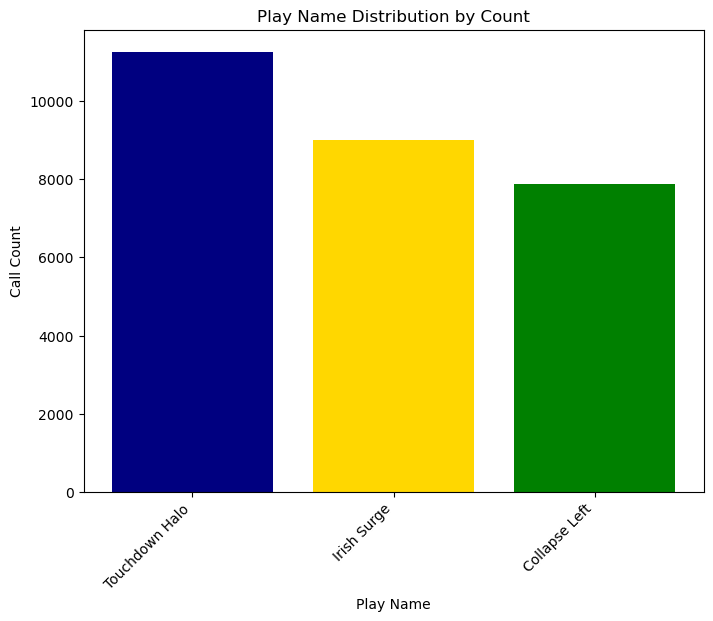

In [97]:
play_name_df = playcall_df.merge(play_dim_df, on='play_key', how='inner')
play_name_df = play_name_df.groupby('play_name').size().reset_index(name='call_count')
play_name_df = play_name_df.sort_values(by='call_count', ascending=False)

## plotting the distribution of play names as a bar chart
plt.figure(figsize=(8, 6))
plt.bar(play_name_df['play_name'], play_name_df['call_count'], color=['navy', 'gold', 'green'])
plt.title('Play Name Distribution by Count', fontsize=12)
plt.xlabel('Play Name', fontsize=10)
plt.ylabel('Call Count', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.show()

#### Distribution of Play Types

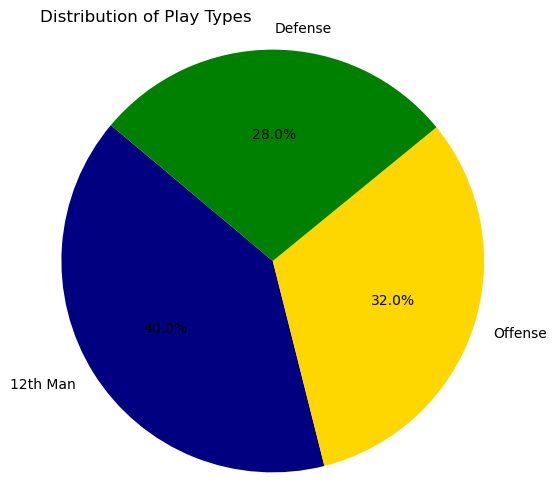

In [78]:
play_type_df= playcall_df.merge(play_dim_df, on='play_key', how='inner')
play_type_df = play_type_df.groupby('type').size().reset_index(name='play_count')
play_type_df = play_type_df.sort_values(by='play_count', ascending=False)

# plotting the distribution of play type as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    play_type_df['play_count'],
    labels=play_type_df['type'],
    autopct='%1.1f%%',
    startangle=140,
    colors= ['navy', 'gold', 'green'] 
)
plt.title('Distribution of Play Types',loc='left', fontsize=12)
plt.axis('equal') 
plt.show()

#### Analyze the Distribution of Play Durations (milliseconds)

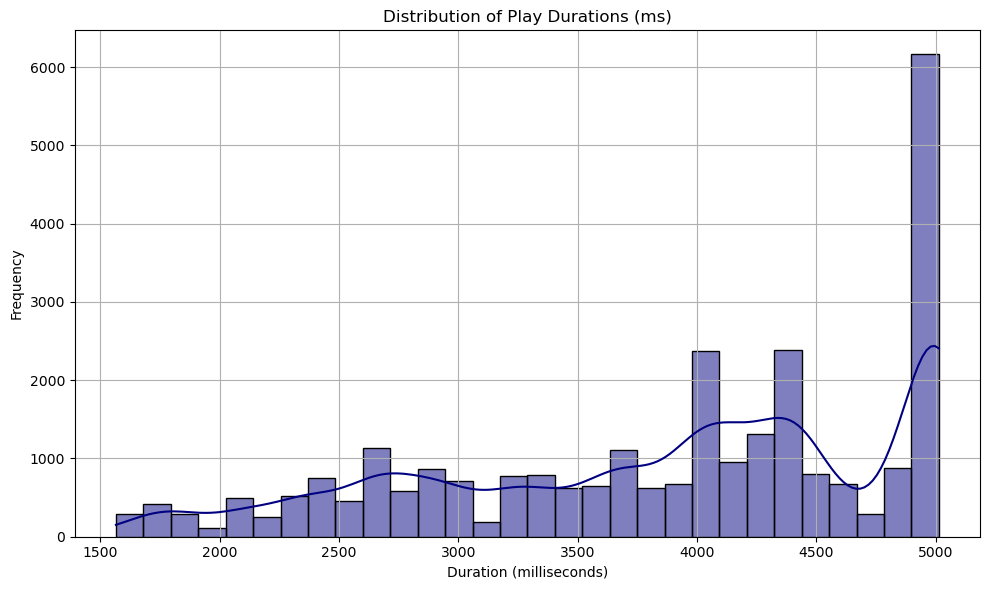

In [83]:
#merging df to include the durationMs column
duration_play_df = pd.merge(signal_header_df,playcallattempt_fact,left_on=['signalID'],right_on=['signal_recording_id'],how='inner')

#plotting the distribution of play durations 
plt.figure(figsize=(10, 6))
sns.histplot(duration_play_df['durationMs'], bins=30, kde=True, color='navy')

plt.title('Distribution of Play Durations (milliseconds)')
plt.xlabel('Duration (milliseconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Top 5 Shortest and Longest Plays by Duration (milliseconds)

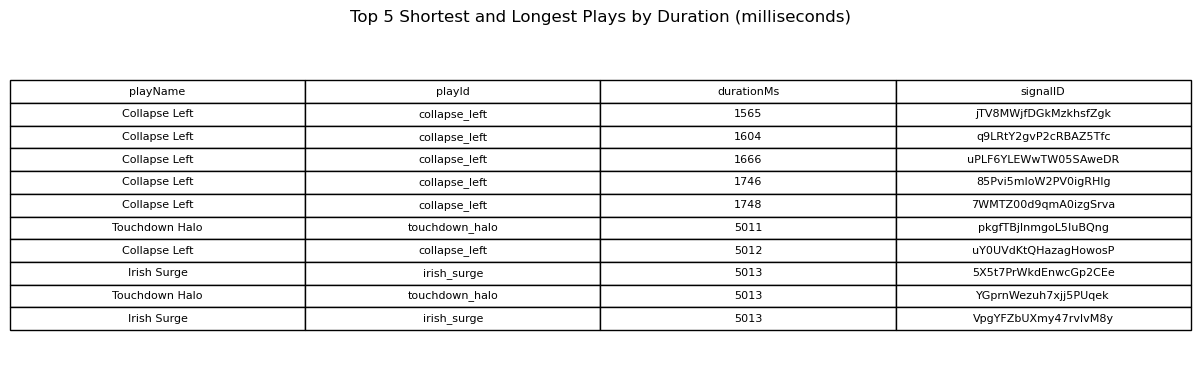

In [90]:
durationms_df = signal_header_df.sort_values(by='durationMs')
shortest_plays = durationms_df.head(5)
longest_plays = durationms_df.tail(5) 

#creating a table to display the plays with the shortest and longest duration ms
table_df = pd.concat([shortest_plays, longest_plays])
table_df = table_df[['playName', 'playId', 'durationMs', 'signalID']]

#plotting the figure and table
plt.figure(figsize=(12, 4))
plt.axis('off')
table = plt.table(
    cellText=table_df.values,
    colLabels=table_df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)
plt.title('Top 5 Shortest and Longest Plays by Duration (milliseconds)', fontsize=12)
plt.tight_layout()
plt.show()

#### Relationship Between Acceleration and Rotation

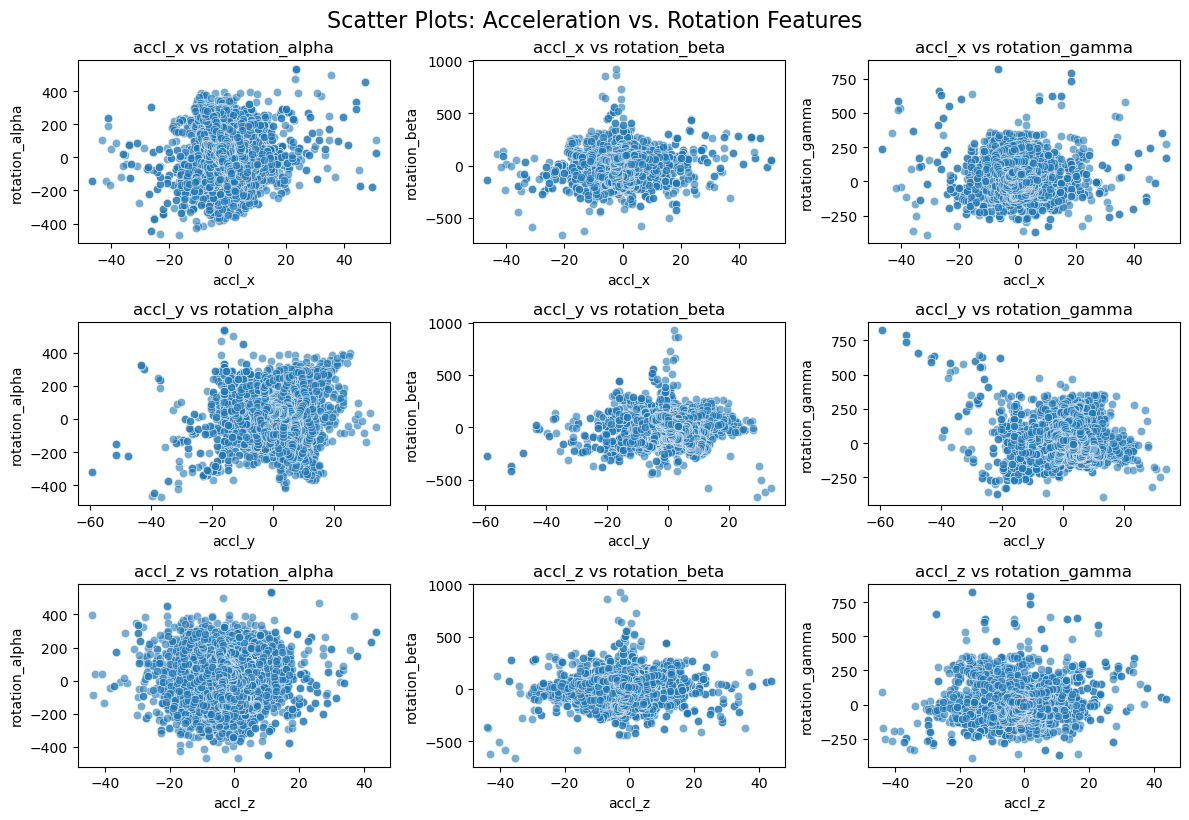

In [102]:
accel_cols = ['accl_x', 'accl_y', 'accl_z']
rotation_cols = ['rotation_alpha', 'rotation_beta', 'rotation_gamma']

#creatting a 3x3 grid of the scatterplots to display the relationship of acceleration and rotation
plt.figure(figsize=(12, 8))
plot_idx = 1

for a_col in accel_cols:
    for r_col in rotation_cols:
        plt.subplot(3, 3, plot_idx)
        sns.scatterplot(
            data=playcallattempt_fact,
            x=a_col,
            y=r_col,
            alpha=0.6
        )
        plt.title(f'{a_col} vs {r_col}')
        plt.xlabel(a_col)
        plt.ylabel(r_col)
        plot_idx += 1

plt.tight_layout()
plt.suptitle('Scatter Plots: Acceleration vs. Rotation Features', fontsize=16, y=1.02)
plt.show()

#### Descriptive Statistics of Numeric Fields

In [114]:
#playcallattempt_fact
duration_play_df[['accl_x', 'accl_y', 'accl_z', 'rotation_alpha', 'rotation_beta', 'rotation_gamma','durationMs']].describe()

,accl_x,accl_y,accl_z,rotation_alpha,rotation_beta,rotation_gamma,durationMs
count,28136.000000,28136.000000,28136.000000,28136.000000,28136.000000,28136.000000,28136.000000
mean,-0.154291,0.580967,-0.648609,-1.132305,-5.534990,6.248086,3871.479955
std,4.152269,4.640357,4.501244,79.201629,66.642888,60.820929,964.802106
min,-46.700000,-59.400000,-44.005628,-468.500000,-663.420372,-391.751265,1565.000000
25%,-1.200000,-0.700000,-1.469672,-25.830516,-24.674888,-12.084303,3136.000000
50%,-0.058974,0.085074,-0.100000,-0.452808,-0.612474,0.525353,4055.000000
75%,0.900000,2.000160,0.600000,20.708307,17.229389,18.968523,4787.500000
max,51.000000,33.728049,43.700000,535.100000,926.802357,823.600000,5013.000000


#### Correlaion Matrix of Numeric Fields

In [116]:
duration_play_df[['accl_x', 'accl_y', 'accl_z', 'rotation_alpha', 'rotation_beta', 'rotation_gamma','durationMs']].corr(numeric_only=True)

,accl_x,accl_y,accl_z,rotation_alpha,rotation_beta,rotation_gamma,durationMs
accl_x,1.000000,0.074214,0.048160,-0.033012,0.101886,0.020208,0.010664
accl_y,0.074214,1.000000,0.089364,0.007522,-0.062585,-0.122010,-0.043653
accl_z,0.048160,0.089364,1.000000,-0.040319,-0.010116,-0.065612,-0.006921
rotation_alpha,-0.033012,0.007522,-0.040319,1.000000,0.042316,-0.086370,0.034981
rotation_beta,0.101886,-0.062585,-0.010116,0.042316,1.000000,0.178124,-0.025609
rotation_gamma,0.020208,-0.122010,-0.065612,-0.086370,0.178124,1.000000,0.067453
durationMs,0.010664,-0.043653,-0.006921,0.034981,-0.025609,0.067453,1.000000


#### Outliers of Acceleration and Rotation

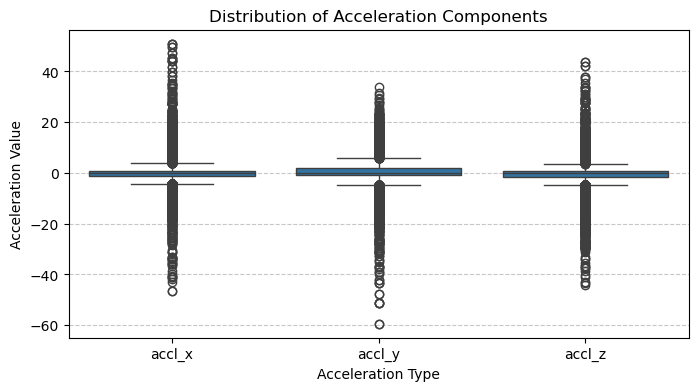

In [259]:
accl_columns = ['accl_x', 'accl_y', 'accl_z']

playcallattempt_fact_melted = playcallattempt_fact.melt(id_vars=['play_key'],value_vars=accl_columns,var_name='acceleration_type',value_name='acceleration_value')
plt.figure(figsize=(8, 4))
sns.boxplot(data=playcallattempt_fact_melted, x='acceleration_type', y='acceleration_value')
plt.title('Distribution of Acceleration Components')
plt.xlabel('Acceleration Type')
plt.ylabel('Acceleration Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

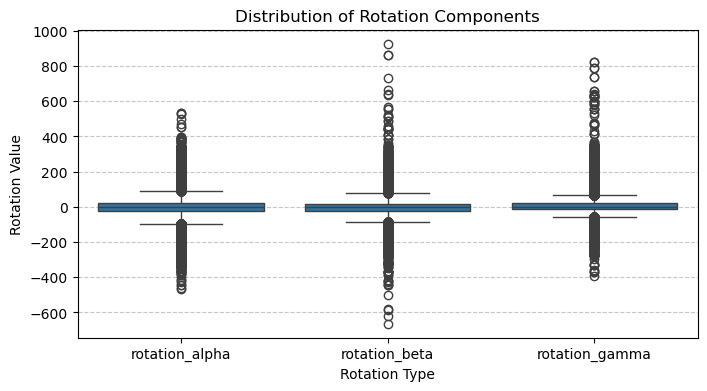

In [260]:
rotation_columns = ['rotation_alpha', 'rotation_beta', 'rotation_gamma']

playcallattempt_fact_melted = playcallattempt_fact.melt(id_vars=['play_key'],value_vars=rotation_columns,var_name='rotation_type',value_name='rotation_value')
plt.figure(figsize=(8, 4))
sns.boxplot(data=playcallattempt_fact_melted, x='rotation_type', y='rotation_value')
plt.title('Distribution of Rotation Components')
plt.xlabel('Rotation Type')
plt.ylabel('Rotation Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Analyzing Rotation and Acceleration Trends by Play Type

In [147]:
rotation_columns = ['rotation_alpha', 'rotation_beta', 'rotation_gamma']
playcallattempt_fact.groupby('play_key')[rotation_columns].mean()

,rotation_alpha,rotation_beta,rotation_gamma
play_key,,,
1,-13.270034,3.564163,-1.723347
2,6.624669,-2.358798,-2.428930
3,1.158231,-14.432358,18.749949


In [148]:
acceleration_columns = ['accl_x', 'accl_y', 'accl_z']
playcallattempt_fact.groupby('play_key')[acceleration_columns].mean()

,accl_x,accl_y,accl_z
play_key,,,
1,-0.140215,0.338832,-0.475420
2,-0.105001,0.622649,-0.398443
3,-0.203494,0.716951,-0.969458


# Predictive Model

The play key is a unique identifier and able to be used as way to determine which play is occuring. Collaspe Left is reference to 1, Irish Surge is refrenced to 2 and Touchdown Halo is refrenced to 3. As expected given the very different gestures/movements, acceleration and rotation are key predictors in signaling based on the prediction model. Additional features as more gestures are added would help increase accuracy in identifying the signaling call especially the more similary the calls become. 

In [252]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [243]:
sensor_features = ['accl_x', 'accl_y', 'accl_z', 'rotation_alpha', 'rotation_beta', 'rotation_gamma']

In [244]:
aggregated_features = playcallattempt_fact.groupby('signal_recording_id')[sensor_features].agg(['mean', 'std', 'min', 'max', 'median'])
aggregated_features.columns = ['_'.join(col) for col in aggregated_features.columns] 

In [246]:
X = aggregated_features.reset_index(drop=True)
y = labels.reset_index(drop=True)

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2230)

In [249]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [250]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [258]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9167


In [251]:
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.89      1.00      0.94         8
           2       1.00      0.75      0.86         8
           3       0.89      1.00      0.94         8

    accuracy                           0.92        24
   macro avg       0.93      0.92      0.91        24
weighted avg       0.93      0.92      0.91        24



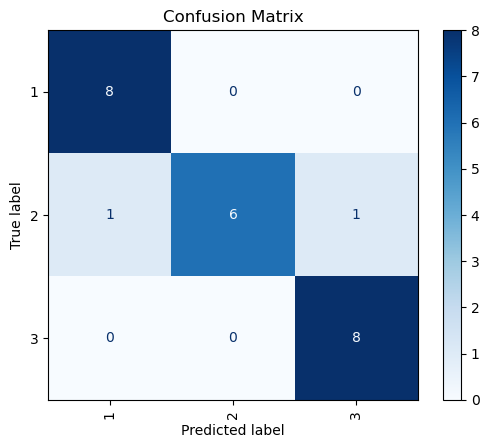

In [256]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title('Confusion Matrix')
plt.show()